In [19]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
library(dbplyr)
library(DBI)
library(RPostgres)
library(lubridate)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

# Algerian Forest Fires and Weather
## Background and Introduction:
As our climate changes, it is important to understand the conditions which can lead to forest fire ignition. Due to increasing temperatures, summer temperatures have been increasing, resulting in dryer heat (lower humidity), dryer forests, which can lead to forest fires. Rising temperatures result in inequality of temperature between the sky and the earth, leading to further likelihood of lightning--along with fire-related human activites, igniting forces are sure to lead to forest fires. ([Source](https://climateatlas.ca/forest-fires-and-climate-change#:~:text=Dry%20heat%20helps%20create%20more,rising%20temperature%20of%20the%20Arctic.))


## Q: What weather conditions result in a forest fire in Algerian Forest Areas?
## Dataset:
"The Algerian Forest Fires Dataset" ([link](https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++)) provides information on forest fires in two areas: Sidi-Bel Abbas and Bejaia regions. The data was taken from June 2012- September 2012, and contains information on the following data:

1. Date: Day, month, year
*Weather data*

2. Temp: temperature noon (Celsius): 22 to 42
3. RH: Relative Humidity (%): 21 to 90
4. Ws: Wind speed (km/h): 6 to 29
5. Rain: total day (mm): 0 to 16.8

*FWI Components*

6. Fine Fuel Moisture Code (FFMC) index: 28.6 to 92.5
7. Duff Moisture Code (DMC) index: 1.1 to 65.9
8. Drought Code (DC) index: 7 to 220.4
9. Initial Spread Index (ISI): 0 to 18.5
10. Buildup Index (BUI): 1.1 to 68
11. Fire Weather Index (FWI): 0 to 31.1

*Classes*
12. Fire or Not Fire

Fire Weather Index (FWI) is a general measure used to predict the intensity of a potential fire in the area, & takes into account each component when calculating this. 

## Methods
For our analysis, we will be looking at weather data observations of Temperature, Relative Humidity (RH), Wind speed (WS), Rain, FWI Components as well as the overall FWI. We're interested in the contribution of the weather in forest fire ignition, and how this might correlate with FWI.

To achieve this, we will be performing a classification using the Algerian forest fires dataset. First, we must tidy our data. To do this, we load the data into Jupyter and specify which columns we want as integers, doubles, or characters. Secondly, we will work to merge the two tables for each region that are in our dataset; we will split the dataset into two tables and save them to the objects 'bejaia_region' and 'sidi_bel_region', which correspond to which region the data was collected from. Then, we will combine both tables into one, using 'rbind' and saving that to an object called 'forest_fire_data'. Next, we will select which variables we wish to keep in our data set (day, month, Temperature, FWI, RH, Ws, Rain, Classes) and use the 'mutate' function to use the Classes column as a factor.

Next, we begin creating our recipe. First, we will split our data in to training (75%) and test (25%) sets. Using Classes as the stratification and month, temperature, and FWI as predictors, we create our recipe with our training data.



Potential Visualizations:
- a scattergraph with temperature on the y-axis and then FWI on the x-axis, and coloured by Class.
- a grid with numerous graphs. FWI will be on the x-axis for one, while, all other predictors on their own visualization on the y-axis. Each will be coloured by Class.

Warning message:
“18 parsing failures.
row   col   expected                        actual                                                                                                       file
123 day   an integer Sidi-Bel Abbes Region Dataset 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
123 NA    14 columns 1 columns                     'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
124 day   an integer day                           'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
124 month an integer month                         'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
124 year  an integer year                          'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
... ..... ...

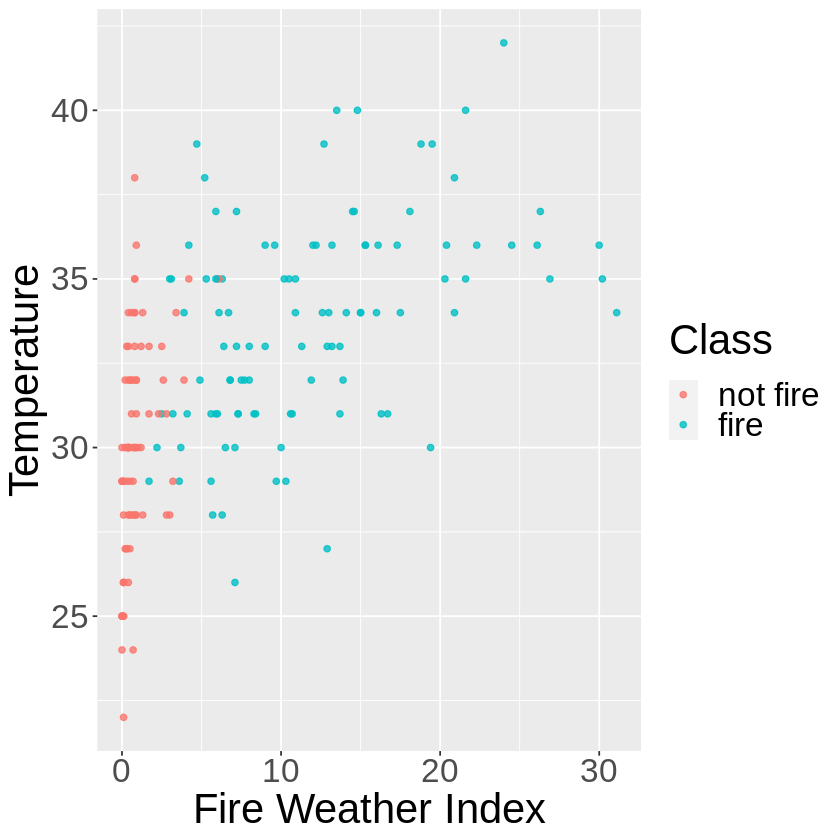

In [27]:
forest_fires_untidy <- read_csv(file = "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", 
                                skip = 1, col_names = TRUE, col_types = cols_only(
                                      day = col_integer(),
                                      month = col_integer(),
                                      year = col_integer(),
                                      Temperature = col_double(),
                                      RH = col_double(),
                                      Ws = col_double(),
                                      Rain = col_double(),
                                      FFMC = col_double(),
                                      DMC = col_double(),
                                      DC = col_double(),
                                      ISI = col_double(),
                                      BUI = col_double(),
                                      FWI = col_double(),
                                      Classes = col_character()))  
  
bejaia_region <- forest_fires_untidy %>%
    slice(1:122) %>%
    mutate(region = "bejaia")

sidi_bel_region <- forest_fires_untidy %>%
    slice(125:246) %>%
    mutate(region = "sidi bel abbes")

forest_fire_data <- rbind(bejaia_region, sidi_bel_region) 

fire_data <- forest_fire_data %>%
     filter(!is.na(Classes)) %>%
     select(day, month, Temperature, FWI, RH, Ws, Rain, Classes) %>%
     mutate(Classes = as_factor(Classes))

set.seed(1)
fire_split <- initial_split(fire_data, prop = 0.75, strata = Classes)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

fire_test_plot <- fire_train %>%
    ggplot(aes(x = FWI, y = Temperature, color = Classes))+
    geom_point(alpha = 0.8)+
    scale_fill_distiller(palette = "YlOrRd") +
    labs(x = "Fire Weather Index", y = "Temperature", color = "Class")+
    theme(text = element_text(size = 25))

fire_test_plot

In [28]:
fire_train %>%
    group_by(Classes) %>%
    summarize(n = n(),
    average_temp = mean(Temperature),
    average_FWI = mean(FWI))

`summarise()` ungrouping output (override with `.groups` argument)



Classes,n,average_temp,average_FWI
<fct>,<int>,<dbl>,<dbl>
not fire,80,29.97500,0.92375
fire,103,33.70874,11.84854


Now, we will find the optimum K value by performing a grid v-fold and setting neighbours to tune in our 'knn_spec'. CONTINUE FROM HERE WHEN CODE IS DONE

[1] 3

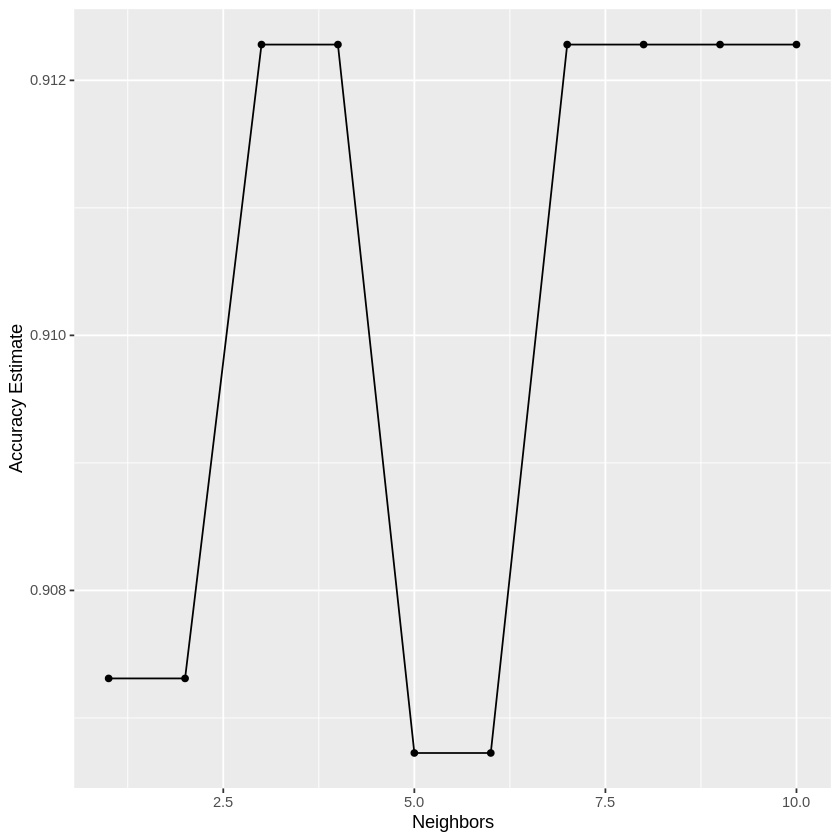

In [29]:
set.seed(1)
fire_vfold <- vfold_cv(fire_train, v = 10,strata = Classes)

best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

fire_recipe <- recipe(Classes ~ month + Temperature + FWI, data = fire_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1)) 

knn_results <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(best_knn_spec) %>%
    tune_grid(resamples = fire_vfold, grid = k_vals) %>%
    collect_metrics()

accuracies <- knn_results %>%
    filter(.metric == "accuracy")

accuracy_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs (x = "Neighbors", y = "Accuracy Estimate")
accuracy_plot

best_neighbor <- accuracies %>%
    arrange(desc(mean)) %>%
    slice(1) %>%
    pull(neighbors)

best_neighbor

In [30]:
set.seed(1)
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_neighbor) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_best_fit <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_best_spec) %>%
    fit(fire_train)

fire_best_test_predictions <- predict(knn_best_fit, fire_test) %>%
    bind_cols(fire_test)

fire_best_accuracy <- fire_best_test_predictions %>%
        metrics(truth = Classes, estimate = .pred_class)
fire_best_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9
kap,binary,0.8
